In [2]:
!pip install yfinance --quiet
!pip install yahooquery --quiet
!pip install requests_html --quiet
!pip install ydata_profiling --quiet
!pip install PyPortfolioOpt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 38.3 MB/s et

In [3]:
# Modules imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
from yahooquery import Screener
import requests
from requests_html import HTMLSession
from datetime import datetime
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

# The goal
Inspired by the G-Reseach competition in [Kaggle](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview) and [this portfolio optimizer tool](https://www.portfoliovisualizer.com/optimize-portfolio)

Our aim is to create a Streamlit App to generate, for a given:
  - Porfolio of cryptocurrencies.
  - Budget.

The optimized ratio of chosen currencies by maximizing the Sharpe Ratio

We begin the exercice by a step by step guided notebook to cover all the inner working of task completion before wrapping everything in **App.py** script.

# The Data

We'll start with a selection of 5 most popular crypto currencies by market capitalization.

## Getting Data

For scraping historical trading data of the crypto currencies, we rely on Yahoo! finance API.
Fortunatly there is a python [project](https://pypi.org/project/yfinance/) who offers an easy pythonic way to get data.

In [4]:
# Scraping list of 5 most popular crypto tickets (cc)

session = HTMLSession()
num_currencies=5
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
cc = df.Symbol.tolist()
cc

['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD']

In [6]:
# For the given cryptocurrencies, we grab the daily histrical closing price data since 2020:

tickers = yf.Tickers(cc)
end_date = datetime.now().strftime('%Y-%m-%d')
data = tickers.history(start='2020-01-01',end=end_date,interval='1d')['Close']
data

[*********************100%***********************]  5 of 5 completed


,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-01-01,13.689083,7200.174316,130.802002,1.004079,0.999836
2020-01-02,13.027011,6985.470215,127.410179,1.005017,1.001565
2020-01-03,13.660452,7344.884277,134.171707,1.005273,1.004192
2020-01-04,13.891512,7410.656738,135.069366,1.009466,1.007472
2020-01-05,14.111019,7411.317383,136.276779,1.008497,1.006197
...,...,...,...,...,...
2023-04-22,331.995087,27817.500000,1874.228638,1.000107,1.000185
2023-04-23,330.618835,27591.384766,1862.062012,0.999894,1.000023
2023-04-24,331.245880,27525.339844,1842.757446,1.000042,1.000121


## Preprocessing Data

In [7]:
# missing data
data.isna().sum()

BNB-USD     0
BTC-USD     0
ETH-USD     0
USDC-USD    1
USDT-USD    1
dtype: int64

In [8]:
data.dtypes

BNB-USD     float64
BTC-USD     float64
ETH-USD     float64
USDC-USD    float64
USDT-USD    float64
dtype: object

In [9]:
data = data.dropna()

In [10]:
data.isna().sum()

BNB-USD     0
BTC-USD     0
ETH-USD     0
USDC-USD    0
USDT-USD    0
dtype: int64

Other than missing value, it seems there is no issues with observations to handle, we save the downloaded data as a csv file for future exploitation.

In [11]:
# Save data to csv for future manipulations
data.to_csv('data')

# EDA

Having no issues with data, the next step is to explore their main statistical features.

In [12]:
data.describe()

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
count,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000
mean,247.454117,28450.991969,1687.046527,1.000643,1.000588
std,181.496776,16382.410085,1211.609600,0.004100,0.002554
min,9.386050,4970.788086,110.605873,0.970124,0.974248
25%,28.519130,13548.505859,429.136520,0.999887,1.000021
50%,283.820984,23561.212891,1579.704590,1.000063,1.000260
75%,372.056702,41595.279297,2567.834106,1.000332,1.000802
max,675.684082,67566.828125,4812.087402,1.044029,1.053585


And distributions.

<Axes: >

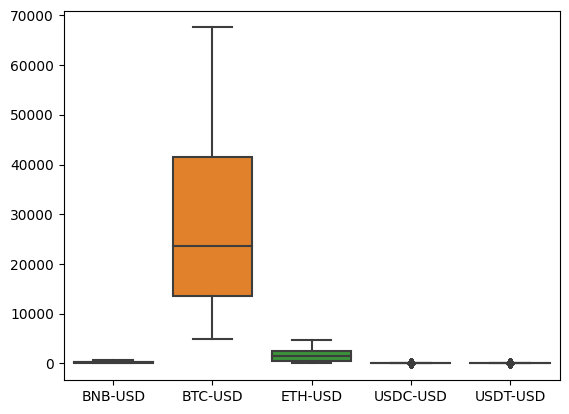

In [18]:
sns.boxplot(data)

<Axes: >

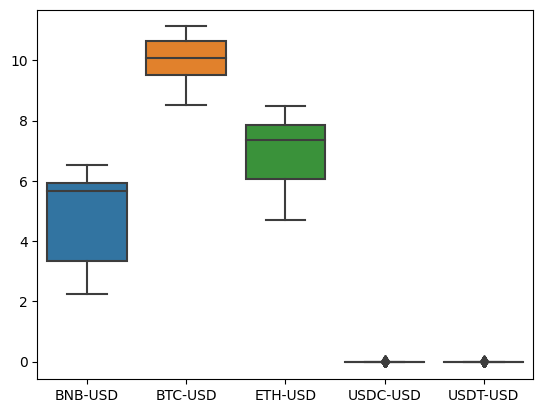

In [19]:
log_data = np.log(data)
sns.boxplot(log_data)

It seems we have two groups of currencices.

But before to jump to conclusions, let's inspect the relation between each two currencies.

## Correlation Analysis

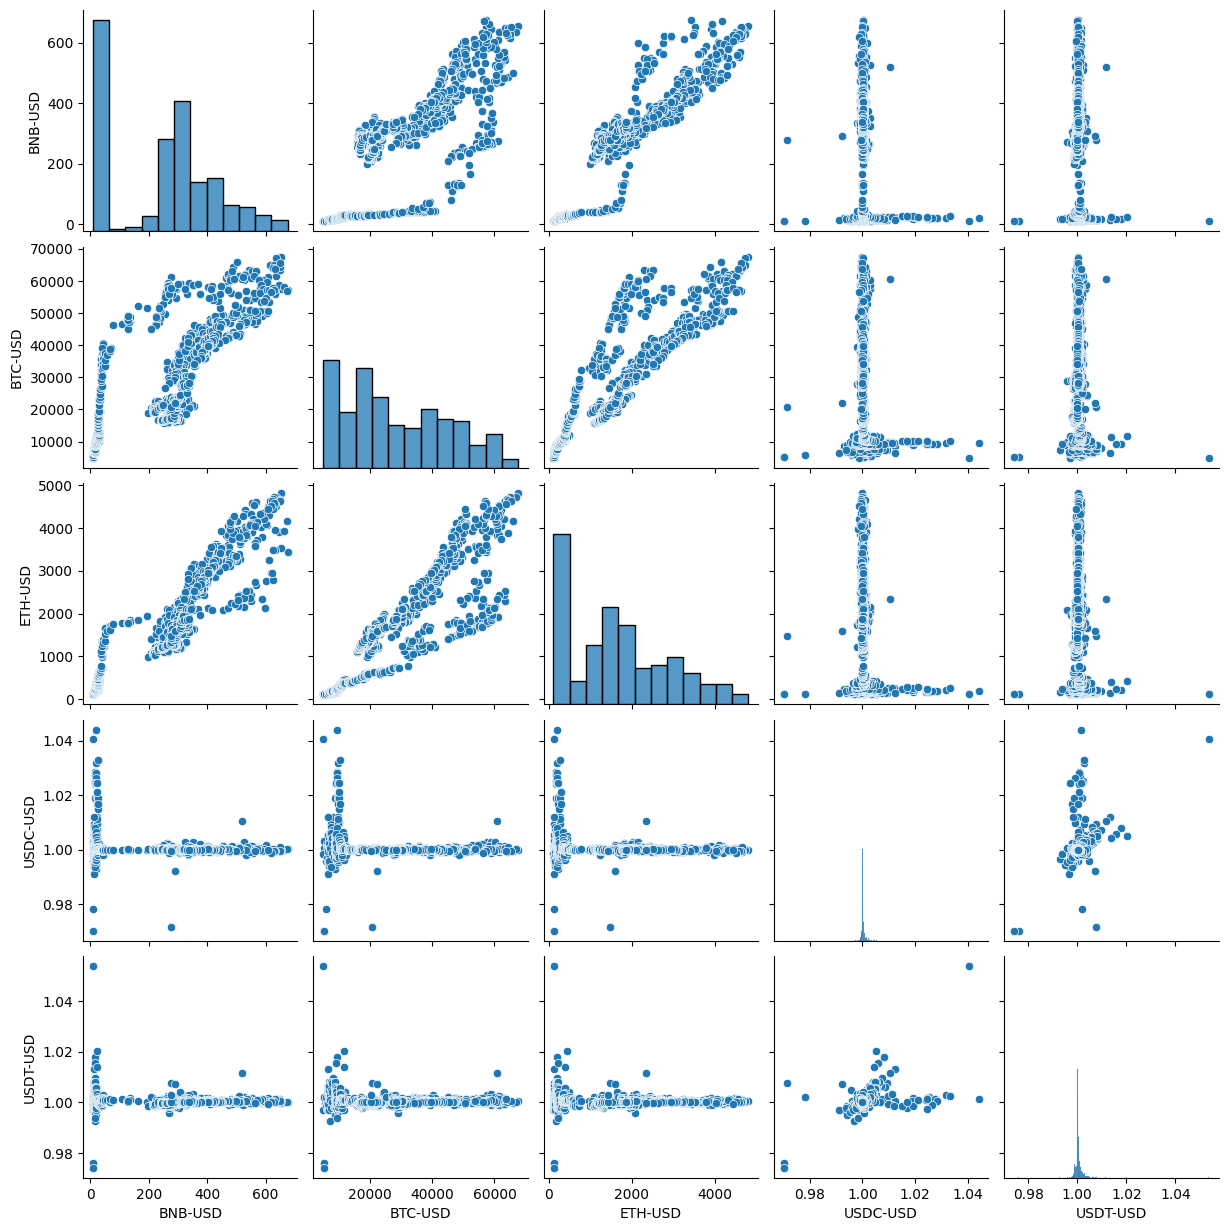

In [20]:
# Ploting each two currencies at a time
sns.pairplot(data)

<Axes: >

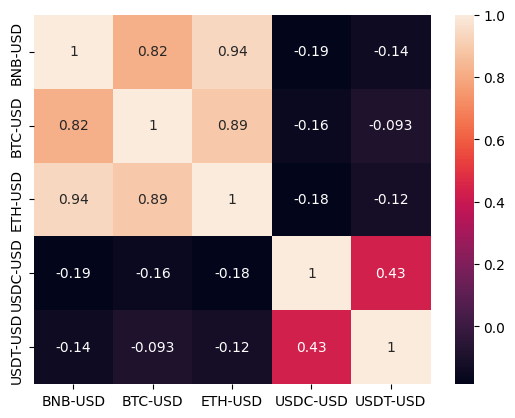

In [21]:
# Calculating and visualizing the correlation between each currency
corr = data.corr()
sns.heatmap(corr, annot=True)

Indeed, two groups of hight and low correlated currencies.

## Volatility Analysis

In finance, mesuring volatilty is assessing how much of a fluctuating an asset is, and the more an asset is volatile, the riskier it is and more difficult to predict.

In [23]:
df = data.copy()

In [24]:
df = np.log(df/df.shift()).rolling(window=365).std()*365**.5

Unlike stock markets where we do specify 252 days of trading per year.
Crypto markets are 24/7 traded throughtout the year.

The choice of 365 days of rolling window to calculate the annulized volatility.

In [25]:
df = df.dropna()

In [26]:
df

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-12-31,0.974188,0.766632,1.001485,0.106998,0.106501
2021-01-01,0.972838,0.765921,1.001114,0.106994,0.106495
2021-01-02,0.971830,0.769314,1.001467,0.106994,0.106470
2021-01-03,0.974283,0.769468,1.026627,0.106913,0.106420
2021-01-04,0.974236,0.770008,1.028306,0.106909,0.106413
...,...,...,...,...,...
2023-04-21,0.678769,0.614955,0.827096,0.036260,0.008794
2023-04-22,0.679511,0.615021,0.827195,0.036261,0.008794
2023-04-23,0.679403,0.615039,0.827175,0.036261,0.008795


In [28]:
import plotly.graph_objects as go
def plot_graph(col,title,xlabel,ylabel,df):
    data = []
    for i in range(len(col)): 
        plot = go.Scatter(x=df.index,y=df[col[i]], name=col[i])
        data.append(plot)
    
    layout = go.Layout(title= title ,
                    xaxis=dict(title=xlabel),
                    yaxis=dict(title=ylabel ), 
                    width = 690, 
                    height = 500, 
                    autosize = True)

    fig = go.Figure(data=data, layout=layout)
    
    fig.show()
    
title = "Annualized Volatility Plot"
xlabel = 'Date'
ylabel = 'Closing prive volatility'
df = df
col = list(data.columns.values)

plot_graph(col,title,xlabel,ylabel,df)

We Can identify two groups of correlated currencies:


*   Hight Volatility currencies consisted of:
    1.   BitCoin (BTC)
    2.   Etherium (ETH)
    3.   Binance Coin (BNB)


*   Low Volatility with:
    1.   USD Coin (USDC)
    2.   Tether (USDT)


# Modeling
For the modeling section, we rely on Mean-variance optimization (MVO) solution provided by PyPortfolioOpt Library.

The MVO solution is constrained by maximizing the Sharpe ratio which reputable to indicate how well the risk-ajusted performance a portfolio can be, 

The higher the ratio (preferably above 1) the better investment decision is.





In [29]:
# Calculating the return and 
mu = mean_historical_return(data)
S = CovarianceShrinkage(data).ledoit_wolf()

In [30]:
mu

BNB-USD     0.950312
BTC-USD     0.329921
ETH-USD     0.739545
USDC-USD   -0.000847
USDT-USD    0.000067
dtype: float64

In [31]:
S

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
BNB-USD,0.745805,0.336786,0.454976,-0.002985,-0.005672
BTC-USD,0.336786,0.346440,0.367472,-0.002300,-0.004733
ETH-USD,0.454976,0.367472,0.595459,-0.003636,-0.006380
USDC-USD,-0.002985,-0.002300,-0.003636,0.010120,0.001866
USDT-USD,-0.005672,-0.004733,-0.006380,0.001866,0.009849


In [41]:
from pypfopt.efficient_frontier import EfficientFrontier
USTB_2Y = 0.0409 #US Treasury Yields over 2 years periods = 4.09% in 04/27/2023
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate= USTB_2Y)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('BNB-USD', 0.6758), ('BTC-USD', 0.0), ('ETH-USD', 0.3242), ('USDC-USD', 0.0), ('USDT-USD', 0.0)])


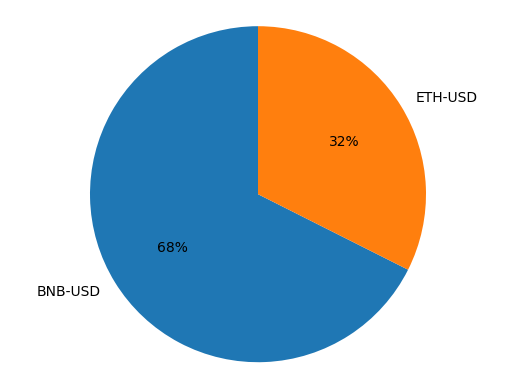

In [42]:
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.0f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [44]:
ef.portfolio_performance(verbose=True)

Expected annual return: 88.2%
Annual volatility: 77.6%
Sharpe Ratio: 1.08


(0.8819813837593873, 0.7762504002144452, 1.0835181321993932)

# Insights Visualization

In [ ]:
#Template

# Porfolio perfomance

## Optimized Portfolio
  # Values & Growth
  # Profits&Loss Generated
  
## Base line Porfolio
  #-> A Portfolio with equal ratios
  # Values & Growth
  # Profits&Loss Generated

## Comparaison
  # Value&Growth
  # Profit&Loss
  

# Streamlit App

Wrapping all previous steps into a Streamlit App

In [ ]:
# Template
# https://streamlit-example-app-download-app-lk16x1.streamlit.app/

# Design
"""
Title [CryptoPortOpt] AKA Crypto Currencies Porfolio' Optimizer

Step1: Select Your Porfolio
  -> The user will be provider with a list of  10 most popular
  crypto by market cap

Step2: Budget(Optional)
  ->  Default to 1000 USA for Porfolio Performation 
  visualizations

Step3: Optimize using MVO/PyPortOpt
  -> Maximize Sharpe Ratio
  Or
  -> Minimise Volatility

Step4: Results/Visualisation
  -> Asset Allocations
  -> Portfolio Performance
"""

In [ ]:
# modules required to run the App
%%writefile requirements.txt
pandas
matplotlib
seaborn
numpy
yfinance
yahooquery
requests
requests_html
datetime
pypfopt

In [ ]:
#%%writefile app.py


# Conclusion

Beyond the App
- Portfolio builder App

# References
[Getting Crypto Symbols](https://stackoverflow.com/a/74656748)

[Portfolio Optimization Using Python](https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb)

[Portfolio Builder](https://github.com/yeungadrian/PortfolioBuilder)

[Portfolio Selection with Graph Algorithms and Deep Learning](https://www.linkedin.com/pulse/portfolio-selection-graph-algorithms-deep-learning-maya-benowitz)

[G-Research Crypto Forecasting](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview)

[G-Research Crypto Forecasting](https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition/notebook#Preprocessing)

[yfinance guide](https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance
)

[Portfolio Optimization with PyPortfolioOpt](https://github.com/paulsg3/PortfolioOptimization/blob/main/Portfolio_Optimization.ipynb)

[PyPortfolioOpt Documentation](https://pyportfolioopt.readthedocs.io/en/latest/)

[Portfolio Optimization using Reinforcement Learning](https://github.com/kvsnoufal/portfolio-optimization)

[Multi-level Columns](https://stackoverflow.com/a/56080234)

[On the non-stationarity of financial time series: Impact on optimal portfolio selection](https://www.researchgate.net/publication/224905259_On_the_non-stationarity_of_financial_time_series_Impact_on_optimal_portfolio_selection)

[Stationary TS](https://analyticsindiamag.com/how-to-make-a-time-series-stationary/)

[Volatility Analysis](https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/)

[Volatility Analysis](https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/)

[Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp)

[Mean-variance Optimization](https://www.investopedia.com/terms/m/meanvariance-analysis.asp)